<a href="https://colab.research.google.com/github/Mateusz-best-creator/Learning_PyTorch/blob/main/PyTorch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with PyTorch

## Data

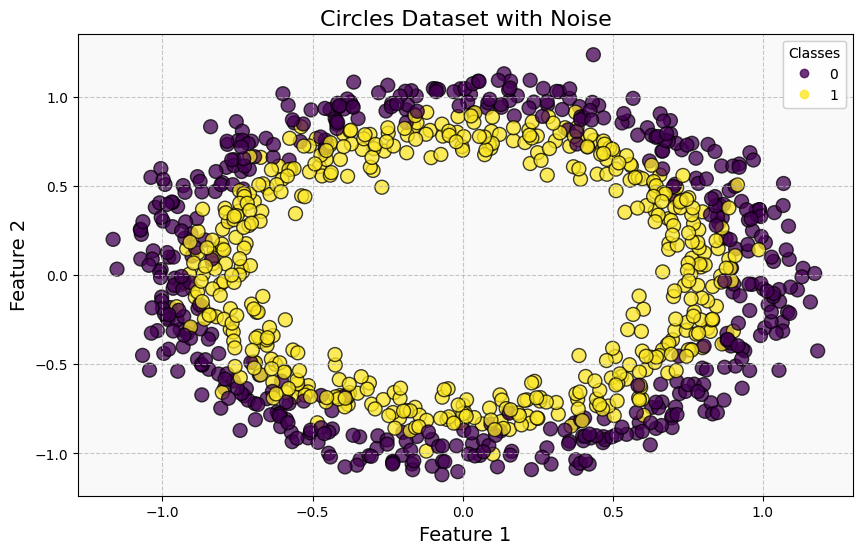

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

circles = make_circles(n_samples=1000, shuffle=True, noise=0.08)
data, labels = circles[0], circles[1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', edgecolor='k', s=100, alpha=0.75)
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.title('Circles Dataset with Noise', fontsize=16)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.show()

### Get training and testing data. Check input and output shapes

In [2]:
import torch

X = torch.from_numpy(data).type(torch.float32)
Y = torch.from_numpy(labels).type(torch.float32)

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### Setup device agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device we are going to use: {device}")
if device == "cuda":
  !nvidia-smi
  pass

Device we are going to use: cpu


## Building a model without non-linearity

In [5]:
from torch import nn

class CircleModelV0(torch.nn.Module):

  def __init__(self):
    super().__init__()
    # Define layers
    self.linear1 = nn.Linear(in_features=2, out_features=5)
    self.linear2 = nn.Linear(5, 1)

  def forward(self, x):
    return self.linear2(self.linear1(x))

# Create model and set it to the appropriate device
model_0 = CircleModelV0().to(device)
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.4675, -0.0188],
         [-0.4268, -0.3665],
         [-0.1779, -0.3788],
         [ 0.6718,  0.0698],
         [-0.3080, -0.3687]], requires_grad=True),
 Parameter containing:
 tensor([-0.0441, -0.5450,  0.2502, -0.5126,  0.2242], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1236, -0.1994, -0.0362,  0.1224, -0.2173]], requires_grad=True),
 Parameter containing:
 tensor([-0.4292], requires_grad=True)]

In [6]:
# Let's replicate the model using nn.Sequential
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                        nn.Linear(in_features=5, out_features=1)).to(device)
list(model_0.parameters())

[Parameter containing:
 tensor([[-0.6661,  0.4178],
         [ 0.1684, -0.0819],
         [ 0.6413, -0.5178],
         [-0.0416, -0.5819],
         [ 0.5732, -0.6268]], requires_grad=True),
 Parameter containing:
 tensor([ 0.1593,  0.1277,  0.0337, -0.4666,  0.4588], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3261, -0.3076, -0.0328, -0.2371, -0.3794]], requires_grad=True),
 Parameter containing:
 tensor([0.0941], requires_grad=True)]

In [7]:
next(model_0.parameters()).device

device(type='cpu')

## Optimizer and Loss Function

In [8]:
# Select optimizer and loss function

# Use momentum SGD
optimizer = torch.optim.SGD(model_0.parameters(),
                            lr=0.001,
                            momentum=0.9)
# Use binary-cross-entropy loss
loss_fn = torch.nn.BCEWithLogitsLoss()

In [9]:
def accuracy_fn(y_true, y_pred):
  # correct = (y_true == y_pred)
  # value = 0
  # for v in correct:
  #   if v == 1:
  #     value += 1
  value = torch.eq(y_true, y_pred).sum().item()
  return value / float(len(y_true)) * 100

accuracy_fn(torch.tensor([1,1,1,1,1]), torch.tensor([1,0,1,1,0]))

60.0

### Calculating predictions

In [10]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device)[:5])
y_logits

tensor([[ 0.1661],
        [-0.3543],
        [ 0.7333],
        [-0.6763],
        [ 0.4464]])

In [11]:
# Let's use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5414],
        [0.4123],
        [0.6755],
        [0.3371],
        [0.6098]])

In [12]:
# Let's round our predictions
torch.round(y_pred_probs)

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [13]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
with torch.inference_mode():
  y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 0., 1., 0., 1.])

## Training and Testing loops


In [14]:
torch.manual_seed(0)

epochs = 100

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze() # Remove extra dimensions
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    test_logits = model_0(X_test.to(device)).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                      y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test Loss : {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.7179234027862549 | Accuracy: 51.0 | Test Loss : 0.7297071814537048 | Test Accuracy: 47.0
Epoch: 10 | Loss: 0.7174052596092224 | Accuracy: 51.0 | Test Loss : 0.7289834022521973 | Test Accuracy: 47.0
Epoch: 20 | Loss: 0.7164353132247925 | Accuracy: 51.125 | Test Loss : 0.7277652025222778 | Test Accuracy: 47.0
Epoch: 30 | Loss: 0.715349555015564 | Accuracy: 51.125 | Test Loss : 0.7264215350151062 | Test Accuracy: 47.0
Epoch: 40 | Loss: 0.7142647504806519 | Accuracy: 51.125 | Test Loss : 0.7250804901123047 | Test Accuracy: 47.0
Epoch: 50 | Loss: 0.7132194638252258 | Accuracy: 51.125 | Test Loss : 0.7237846255302429 | Test Accuracy: 47.0
Epoch: 60 | Loss: 0.7122244834899902 | Accuracy: 51.125 | Test Loss : 0.7225461006164551 | Test Accuracy: 47.0
Epoch: 70 | Loss: 0.7112811803817749 | Accuracy: 51.125 | Test Loss : 0.721366286277771 | Test Accuracy: 47.0
Epoch: 80 | Loss: 0.71038818359375 | Accuracy: 51.125 | Test Loss : 0.7202438116073608 | Test Accuracy: 47.0
Epoch: 90 

## Make Predictions and Evaluate the model

In [15]:
# def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
#     """Plots decision boundaries of model predicting on X in comparison to y.

#     Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
#     """
#     # Put everything to CPU (works better with NumPy + Matplotlib)
#     model.to("cpu")
#     X, y = X.to("cpu"), y.to("cpu")

#     # Setup prediction boundaries and grid
#     x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
#     y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

#     # Make features
#     X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

#     # Make predictions
#     model.eval()
#     with torch.inference_mode():
#         y_logits = model(X_to_pred_on)

#     # Test for multi-class or binary and adjust logits to prediction labels
#     if len(torch.unique(y)) > 2:
#         y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
#     else:
#         y_pred = torch.round(torch.sigmoid(y_logits))  # binary

#     # Reshape preds and plot
#     y_pred = y_pred.reshape(xx.shape).detach().numpy()
#     plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
#     plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
#     plt.xlim(xx.min(), xx.max())
#     plt.ylim(yy.min(), yy.max())

In [16]:
import requests
from pathlib import Path

# Let's import above function from remote repository
if Path("helper_functions.py").is_file():
  print(f"helper_functions.py arleady exist")
else:
  # Download
  url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
  request = requests.get(url)
  print(f"Downloading data from {url}")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

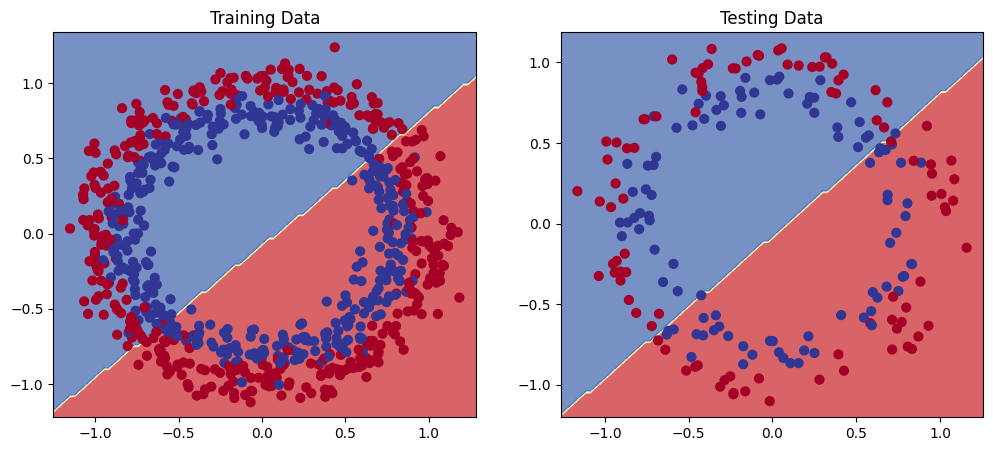

In [24]:
from helper_functions import plot_decision_boundary
import numpy as np

def plot_boundaries(X_train, X_test, y_train, y_test, model):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.title("Training Data")
  plot_decision_boundary(model, X_train, y_train)
  plt.subplot(1, 2, 2)
  plt.title("Testing Data")
  plot_decision_boundary(model, X_test, y_test)

plot_boundaries(X_train, X_test, y_train, y_test, model_0)

In [18]:
# Conclusion: We need non-linearity!!!

## Building a model with non-linearity

In [36]:
# Let's add one more hidden layer, more hidden units and non-linearity (activation functions)
class CircleModelV1(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2, 64)
    self.activation_1 = torch.nn.ReLU()
    self.layer_2 = nn.Linear(64, 64)
    self.activation_2 = torch.nn.ReLU()
    self.layer_3 = nn.Linear(64, 1)

  def forward(self, x):
    return self.layer_3(self.activation_2(self.layer_2(self.activation_1(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (activation_1): ReLU()
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (activation_2): ReLU()
  (layer_3): Linear(in_features=64, out_features=1, bias=True)
)

In [37]:
# We will write most of the things again to practice
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            nesterov=True)
loss_fn = torch.nn.BCEWithLogitsLoss()

### Traing and evaluation loops

In [40]:
torch.manual_seed(0)

epochs = 2000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze() # Remove extra dimensions
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test.to(device)).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_preds)

  if epoch % 150 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Test Loss : {test_loss} | Test Accuracy: {test_acc}")

Epoch: 0 | Loss: 0.6755733489990234 | Accuracy: 64.0 | Test Loss : 0.6754318475723267 | Test Accuracy: 66.5
Epoch: 150 | Loss: 0.6730930209159851 | Accuracy: 66.125 | Test Loss : 0.6730711460113525 | Test Accuracy: 67.0
Epoch: 300 | Loss: 0.670378565788269 | Accuracy: 67.625 | Test Loss : 0.6704705953598022 | Test Accuracy: 70.0
Epoch: 450 | Loss: 0.6673886179924011 | Accuracy: 70.125 | Test Loss : 0.6675517559051514 | Test Accuracy: 72.0
Epoch: 600 | Loss: 0.6641077995300293 | Accuracy: 72.125 | Test Loss : 0.6643252372741699 | Test Accuracy: 74.5
Epoch: 750 | Loss: 0.6604796051979065 | Accuracy: 74.5 | Test Loss : 0.6607636213302612 | Test Accuracy: 76.5
Epoch: 900 | Loss: 0.6564674973487854 | Accuracy: 75.5 | Test Loss : 0.6568069458007812 | Test Accuracy: 78.0
Epoch: 1050 | Loss: 0.6520220041275024 | Accuracy: 77.375 | Test Loss : 0.6524268388748169 | Test Accuracy: 78.5
Epoch: 1200 | Loss: 0.6470829844474792 | Accuracy: 79.25 | Test Loss : 0.6475528478622437 | Test Accuracy: 81.0


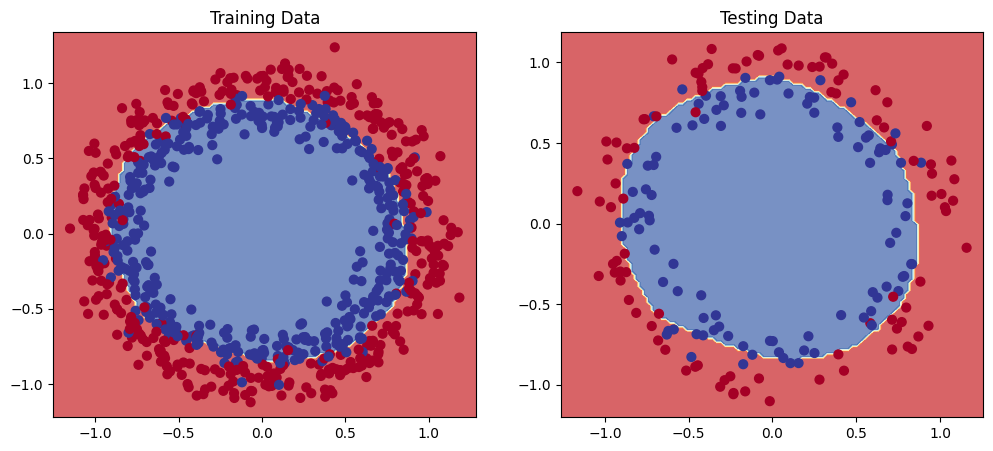

In [41]:
plot_boundaries(X_train, X_test, y_train, y_test, model_1)

# Putting Everything together

## Creating toy datasets

In [90]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# Toy dataset
from sklearn.datasets import make_blobs

NUM_CLASSES = 5
# We will show that even with so little data our model will be able to find meanigful patterns
blobs = make_blobs(n_samples=1000,
                   n_features=2,
                   centers=NUM_CLASSES)
blobs_data, blobs_target = blobs[0], blobs[1]
blobs_data.shape, blobs_target.shape

((1000, 2), (1000,))

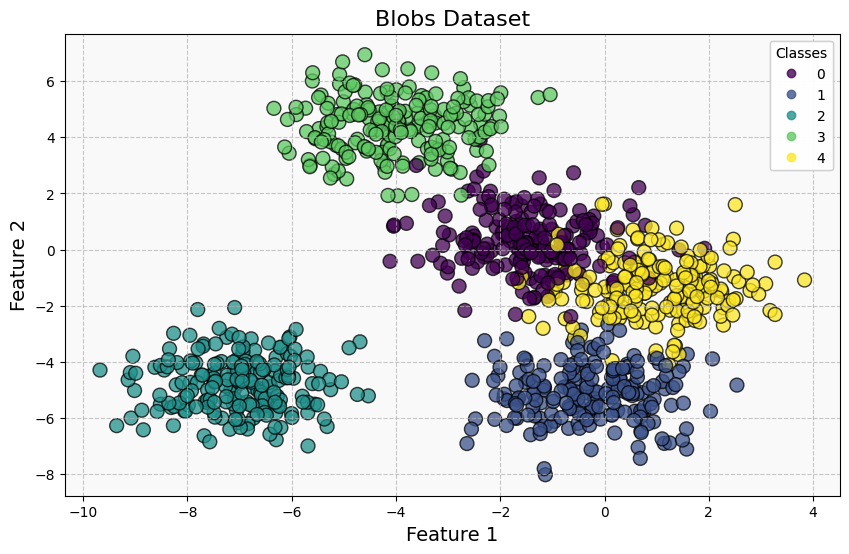

In [91]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(blobs_data[:, 0], blobs_data[:, 1], c=blobs_target, cmap='viridis', edgecolor='k', s=100, alpha=0.75)
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.title('Blobs Dataset', fontsize=16)
plt.xlabel('Feature 1', fontsize=14)
plt.ylabel('Feature 2', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().set_facecolor('#f9f9f9')
plt.show()

## Splitting data into train and test sets

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device we are going to use: {device}")
if device == "cuda":
  !nvidia-smi
  pass

Device we are going to use: cpu


In [93]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(blobs_data, blobs_target,
                                                              test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,
                                                      test_size=0.2)
# Turn data into tensors
X_train = torch.tensor(X_train).to(device).type(torch.float32)
X_valid = torch.tensor(X_valid).to(device).type(torch.float32)
X_test = torch.tensor(X_test).to(device).type(torch.float32)
y_train = torch.tensor(y_train).to(device).type(torch.float32)
y_valid = torch.tensor(y_valid).to(device).type(torch.float32)
y_test = torch.tensor(y_test).to(device).type(torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([640, 2]),
 torch.Size([640]),
 torch.Size([160, 2]),
 torch.Size([160]),
 torch.Size([200, 2]),
 torch.Size([200]))

## Building a model

In [94]:
from torch import nn

class BlobsModel(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.linear_1 = nn.Linear(2, 16)
    self.activation_1 = nn.ReLU()
    self.linear_2 = nn.Linear(16, 16)
    self.activation_2 = nn.ReLU()
    self.linear_3 = nn.Linear(16, NUM_CLASSES)

  def forward(self, x):
    return self.linear_3(self.activation_2(self.linear_2(self.activation_1(self.linear_1(x)))))

model = BlobsModel().to(device)
model

BlobsModel(
  (linear_1): Linear(in_features=2, out_features=16, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=16, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=16, out_features=5, bias=True)
)

## Training and Evaluation loops

In [95]:
# Use SGD optimizer with momentum and Nesterov optimizations
optimizer = torch.optim.SGD(model.parameters(),
                            momentum=0.9,
                            nesterov=True)
loss_fn = torch.nn.CrossEntropyLoss()

In [96]:
epochs = 1000

for epoch in range(epochs):

  model.train()
  optimizer.zero_grad()
  logits = model(X_train)
  loss = loss_fn(logits, y_train.type(torch.long)) # y_pred, y_true
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    valid_logits = model(X_valid.to(device))
    valid_logits = valid_logits.squeeze()
    valid_preds = torch.argmax(torch.softmax(valid_logits, dim=-1), dim=-1)

    valid_loss = loss_fn(valid_logits,
                          y_valid.type(torch.long))
    valid_acc = accuracy_fn(y_true=y_valid,
                           y_pred=valid_preds)

  if epoch % 150 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Accuracy: {acc} | Valid Loss : {valid_loss} | Valid Accuracy: {valid_acc}")

Epoch: 0 | Loss: 1.697382926940918 | Accuracy: 86.5 | Valid Loss : 1.6822378635406494 | Valid Accuracy: 4.375
Epoch: 150 | Loss: 1.0651472806930542 | Accuracy: 86.5 | Valid Loss : 1.1060320138931274 | Valid Accuracy: 54.37499999999999
Epoch: 300 | Loss: 0.6626311540603638 | Accuracy: 86.5 | Valid Loss : 0.7005270719528198 | Valid Accuracy: 65.625
Epoch: 450 | Loss: 0.4799806475639343 | Accuracy: 86.5 | Valid Loss : 0.4897127151489258 | Valid Accuracy: 90.625
Epoch: 600 | Loss: 0.37455981969833374 | Accuracy: 86.5 | Valid Loss : 0.3671364188194275 | Valid Accuracy: 94.375
Epoch: 750 | Loss: 0.3061276376247406 | Accuracy: 86.5 | Valid Loss : 0.28962719440460205 | Valid Accuracy: 95.0
Epoch: 900 | Loss: 0.2602696120738983 | Accuracy: 86.5 | Valid Loss : 0.23908543586730957 | Valid Accuracy: 95.625


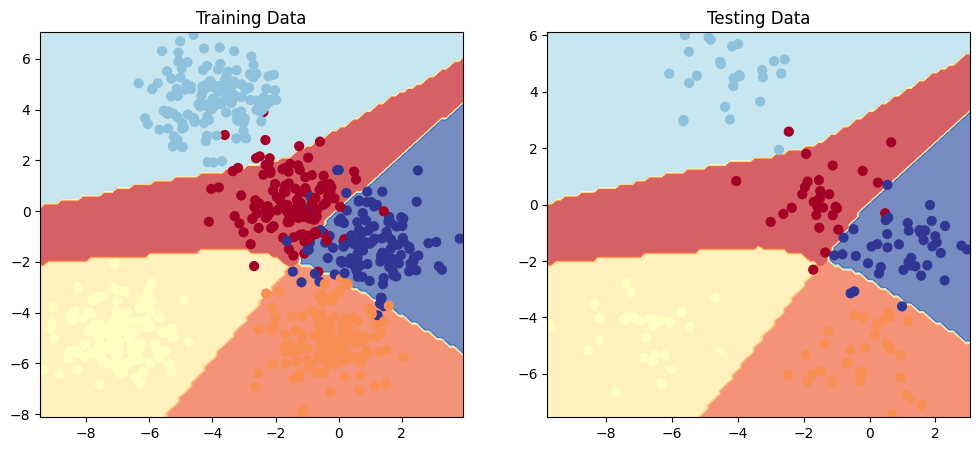

In [108]:
plot_boundaries(X_train, X_valid, y_train, y_valid, model)

## Save our model

In [101]:
torch.save(model.state_dict(), "blobs_model.h5")

## Load our model and evaluate on the test set

In [103]:
loaded_model = BlobsModel()
loaded_model.load_state_dict(torch.load("blobs_model.h5"))
loaded_model.eval()

BlobsModel(
  (linear_1): Linear(in_features=2, out_features=16, bias=True)
  (activation_1): ReLU()
  (linear_2): Linear(in_features=16, out_features=16, bias=True)
  (activation_2): ReLU()
  (linear_3): Linear(in_features=16, out_features=5, bias=True)
)

In [105]:
with torch.inference_mode():
  test_logits = loaded_model(X_test)
test_preds = torch.argmax(torch.softmax(test_logits.squeeze(), dim=-1), dim=-1)
test_preds[:10]

tensor([2, 3, 4, 4, 2, 3, 0, 3, 4, 3])

In [106]:
print(f"Test set accuracy = {accuracy_fn(y_true=y_test, y_pred=test_preds)}")

Test set accuracy = 95.5


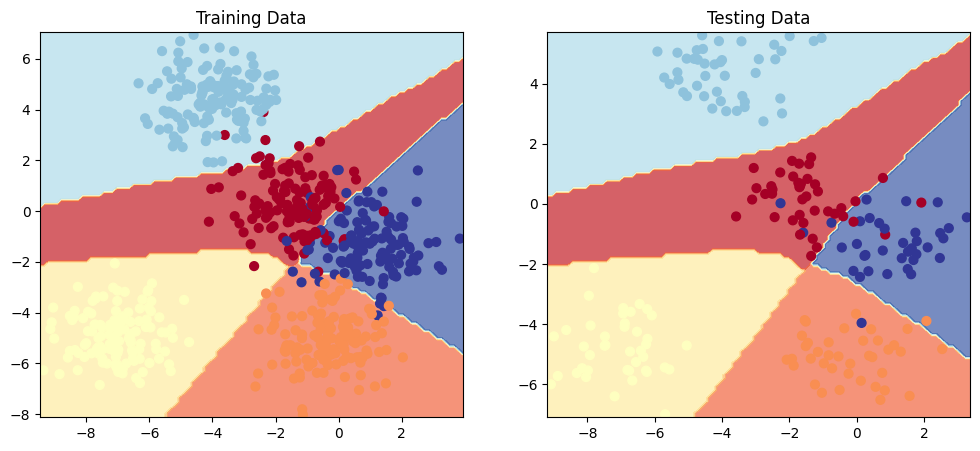

In [109]:
plot_boundaries(X_train, X_test, y_train, y_test, model)